# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
import numpy as np
import pickle

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

BATCH_SIZE = 32
EPOCHS = 100
SEED = 0

## Read circuit data

We read the circuits from the pickled files.

In [2]:
training_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//training//[0-9]*.p")
#validation_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//validation//[0-9]*.p")
test_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//test//[0-9]*.p")

def read_diagrams(circuit_paths):
    circuits = {}
    for serialized_diagram in circuit_paths:
        base_name = Path(serialized_diagram).stem
        f = open(serialized_diagram, "rb")
        diagram = pickle.load(f)
        circuits[base_name] = diagram
    return circuits


training_circuits = read_diagrams(training_circuits_paths) #+ training_circuits_paths[21:])
for key in training_circuits:
    print("training query: ", key)
test_circuits = read_diagrams(test_circuits_paths) #+ [test_circuits_paths[2]] + test_circuits_paths[8:])
#test_circuits = read_diagrams([test_circuits_paths[2]])
for key in test_circuits:
    print("test query: ", key)

training query:  5b
training query:  7c
training query:  9e
training query:  9d
training query:  6d
training query:  7b
training query:  6b
training query:  5d
training query:  10b
training query:  1b
training query:  9c
training query:  9b
training query:  1c
training query:  10d
training query:  10c
training query:  2d
training query:  11b
training query:  11c
training query:  8b
training query:  2c
training query:  2b
training query:  5c
training query:  7d
training query:  6c
training query:  7e
test query:  2a
test query:  7a
test query:  4a
test query:  9a
test query:  11a
test query:  5a
test query:  8a
test query:  6a
test query:  10a
test query:  1a


## Read training and test data

In [3]:
training_data, test_data = None, None
with open(this_folder + "//data//training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(this_folder + "//data//test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
    

def time_to_states(data):
    labeled_data = {}
    for elem in data:
        if elem["name"] in training_circuits.keys() or elem["name"] in test_circuits.keys():
            if elem["time"] < 2001:
                labeled_data[elem["name"]] = [1,0] # corresponds to |0>
            else:
                labeled_data[elem["name"]] = [0,1] # corresponds to |1>
    return labeled_data


training_data_labels = time_to_states(training_data)
test_data_labels = time_to_states(test_data)

#for key in training_data_labels:
#    print("training: ", key)
#for key in test_data_labels:
#    print("test ", key)

## Lambeq optimizer

In [4]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
training_data_labels_l = []
test_data_labels_l = []

for key in training_circuits:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_circuits:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered: ", test_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len([sym for circuit in all_circuits for sym in circuit.free_symbols]))

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 32768
}

Test circuits need to share training circuits' parameters. The parameters that are not covered:  {'D%'__n.l_0, FROM_n@n.l@n.l@n.l@n.l@n.l_n_2, FROM_n@n.l@n.l@n.l@n.l@n.l_n_3, FROM_n@n.l@n.l@n.l@n.l@n.l_n_1, 'features'__n.l_1, 'D%'__n.l_1, FROM_n@n.l@n.l@n.l@n.l@n.l_n_4, FROM_n@n.l@n.l@n.l@n.l@n.l_n_0, company_name__n.l_0, company_id__n.l_2, 'features'__n.l_2, name_pcode_cf__n.l_1, name_pcode_cf__n.l_0, company_id__n.l_1, company_id__n.l_0, company_name__n.l_1, name_pcode_cf__n.l_2, company_name__n.l_2, 'D%'__n.l_2, 'features'__n.l_0}
Total number of circuits:  35
Total number of variables:  1158


## Model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

In [5]:
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)
#model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

## Loss function and evaluation

In [6]:
def acc(y_hat, y):
    #print("y_hat: ", y_hat)
    #print("y: ", y)
    return (np.sum(np.round(y_hat) == y) / len(y)) / 2

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
#acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

eval_metrics = {"acc": acc}

## Trainer

In [7]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

## Training dataset

In [8]:
train_dataset = Dataset(training_circuits_l, training_data_labels_l)

#test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

trainer.fit(train_dataset, evaluation_step=1, logging_step=1)

Epoch 1:    train/loss: 2.0328   valid/loss: -----   train/acc: 0.4200   valid/acc: -----
Epoch 2:    train/loss: 0.9218   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 3:    train/loss: 0.9626   valid/loss: -----   train/acc: 0.4600   valid/acc: -----
Epoch 4:    train/loss: 0.9168   valid/loss: -----   train/acc: 0.5400   valid/acc: -----
Epoch 5:    train/loss: 1.0028   valid/loss: -----   train/acc: 0.4800   valid/acc: -----
Epoch 6:    train/loss: 0.8920   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 7:    train/loss: 1.7410   valid/loss: -----   train/acc: 0.4800   valid/acc: -----
Epoch 8:    train/loss: 1.4320   valid/loss: -----   train/acc: 0.5600   valid/acc: -----
Epoch 9:    train/loss: 0.6603   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 10:   train/loss: 1.1315   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 11:   train/loss: 2.4465   valid/loss: -----   train/acc: 0.5600   valid/acc: -----
Epoch 12: 

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0, 1]
[0, 1]
[0, 1]
[1, 0]
[1, 0]
[0, 1]
[0, 1]
[1, 0]
[0, 1]
[1, 0]
Validation accuracy: 0.5


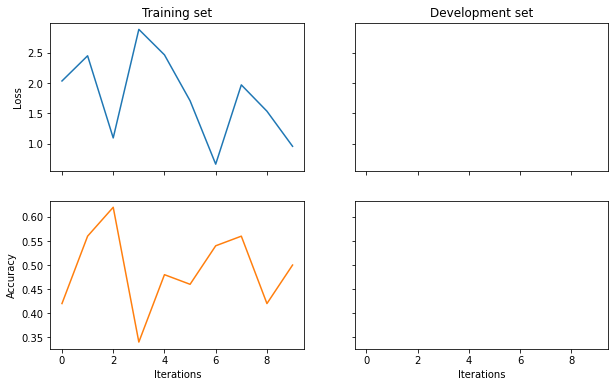

In [9]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)

# print test accuracy
test_acc = acc(model(test_circuits_l), test_data_labels_l)
print('Validation accuracy:', test_acc.item())